Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
Epoch 17 Total Profit: 0.002822667293210679
1/1 [==============================] - 0s 26ms/step
Epoch 18 Total Profit: 0.02875936338164875
1/1 [==============================] - 0s 37ms/step
Epoch 19 Total Profit: 0.005595580525065036
1/1 [==============================] - 0s 31ms/step
Epoch 20 Total Profit: 0.02334829934170035
1/1 [==============================] - 0s 25ms/step


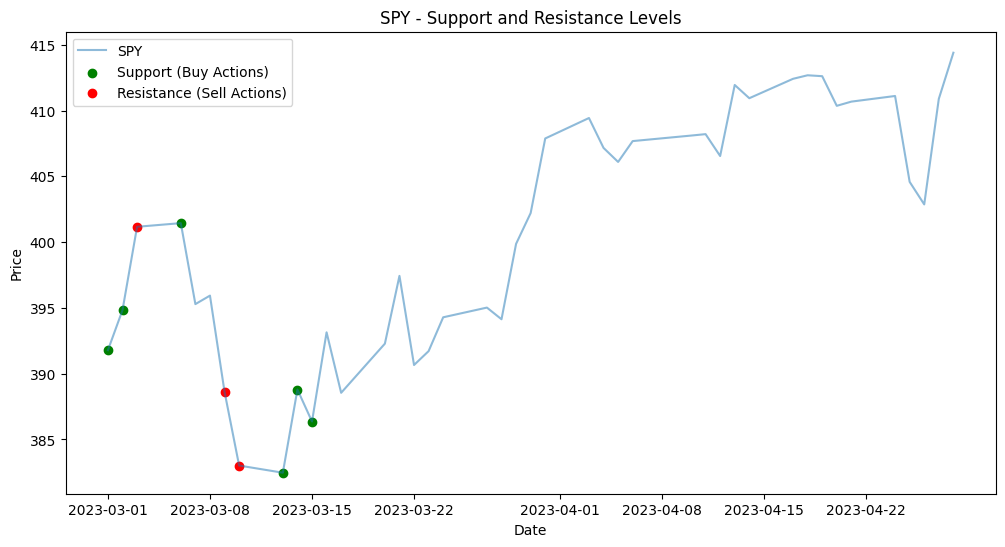

In [1]:
import numpy as np
import yfinance as yf
import random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

ticker = 'SPY'
data = yf.download(ticker, start='2023-03-01', end='2023-05-01')
data['returns'] = data['Adj Close'].pct_change().fillna(0)

class DQLAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(16, input_dim=self.state_size, activation='relu'))  # Reduced complexity
        model.add(Dense(self.action_size, activation='linear'))
        optimizer = Adam(learning_rate=0.005)  # Adjusted learning rate
        model.compile(loss='mse', optimizer=optimizer)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.train_on_batch(state, target_f)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

window_size = 30
action_size = 3
state_size = window_size
agent = DQLAgent(state_size, action_size)
batch_size = 64  # Adjusted batch size
l = len(data) - 1
prev_total_profit = None
converge_count = 0
max_converge_count = 5  # Stop if total_profit is stable for 5 consecutive epochs

for e in range(20):  # Increased epochs for demonstration, but we have early stopping
    total_profit = 0
    for i in range(window_size, l):
        state = data['returns'][i-window_size:i].values.reshape(1, -1)
        next_state = data['returns'][i-window_size+1:i+1].values.reshape(1, -1)
        action = agent.act(state)

        if action == 0:
            reward = data['returns'][i + 1]
        elif action == 1:
            reward = -data['returns'][i + 1]
        else:
            reward = 0

        total_profit += reward
        done = True if i == l - 1 else False
        agent.remember(state, action, reward, next_state, done)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    print(f"Epoch {e + 1} Total Profit: {total_profit}")

    # Check convergence for early stopping
    if prev_total_profit:
        if np.isclose(prev_total_profit, total_profit, atol=1e-4):
            converge_count += 1
        else:
            converge_count = 0

    if converge_count >= max_converge_count:
        print("Converged. Stopping training...")
        break

    prev_total_profit = total_profit

actions = []
for i in range(window_size, len(data)):
    state = data['returns'][i-window_size:i].values.reshape(1, -1)
    action = agent.act(state)
    actions.append(action)

buys = [i for i, a in enumerate(actions) if a == 0]
sells = [i for i, a in enumerate(actions) if a == 1]

plt.figure(figsize=(12, 6))
plt.plot(data['Adj Close'], label='SPY', alpha=0.5)
plt.scatter(data.index[buys], data['Adj Close'].iloc[buys], color='g', marker='o', label='Support (Buy Actions)')
plt.scatter(data.index[sells], data['Adj Close'].iloc[sells], color='r', marker='o', label='Resistance (Sell Actions)')
plt.title('SPY - Support and Resistance Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
